In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [2]:
a=['12','11','10','9','8','7','6','5','4','3','2','1']
b=['07', '06', '05', '04','03','02','01','12','11','10','9','8']
c=['2018','2018','2018','2018','2018','2018','2018','2017','2017','2017','2017','2017']

dates_dict={x:[y,z] for x,y,z in zip(a,b,c) }
print(str(pd.to_datetime(datetime.datetime(int(dates_dict['12'][1]),int(dates_dict['12'][0]),1).date()).date()))
print(dates_dict)

2018-07-01
{'12': ['07', '2018'], '11': ['06', '2018'], '10': ['05', '2018'], '9': ['04', '2018'], '8': ['03', '2018'], '7': ['02', '2018'], '6': ['01', '2018'], '5': ['12', '2017'], '4': ['11', '2017'], '3': ['10', '2017'], '2': ['9', '2017'], '1': ['8', '2017']}


In [3]:
a=[sum,np.mean,np.median,np.std]
b=['1','2','3','4']
dd={x:y for x,y in zip(a,b)}
print(dd[sum])

1


In [4]:
def get_target(table12,OperationsDf,srez):
    a=int(dates_dict[str(srez)][1])
    b=int(dates_dict[str(srez)][0])+1
    if(b>12):
        b=b-12
        a=a+1
    start_date=str(pd.to_datetime(datetime.datetime(a,b,1).date()).date())
    c=int(dates_dict[str(srez)][1])
    d=int(dates_dict[str(srez)][0])+3
    if(d>12):
        d=d-12
        c=c+1
          
    end_date=str(pd.to_datetime(datetime.datetime(c,d,1).date()).date())
          
    
    f2f_abroad=OperationsDf[(OperationsDf['mrch_country_nm']!='RUSSIAN FEDERATION')& (OperationsDf['f2f_ecomm_flg']=='FACE-TO-FACE')]
    f2f_abroad12=f2f_abroad[(f2f_abroad['purchase_dt']>= start_date) & (f2f_abroad['purchase_dt']< end_date)].reset_index(drop=True)
    
    mas_of_uniq_cards12=f2f_abroad12['acct_num_share'].unique()
    table_for_merge12=pd.DataFrame({'acct_num_share':mas_of_uniq_cards12})
    table_for_merge12['has_trip_here']=np.ones(len(table_for_merge12))
    table12=table12.merge(table_for_merge12, on='acct_num_share', how='left')
    table12=table12.fillna(0)
    return table12

In [5]:
def had_trip_last_year(table12,OperationsDf,srez):
    
    
    a=int(dates_dict[str(srez)][1])-1
    b=int(dates_dict[str(srez)][0])+1
    if(b>12):
        b=b-12
        a=a+1
    start_date=str(pd.to_datetime(datetime.datetime(a,b,1).date()).date())
    c=int(dates_dict[str(srez)][1])-1
    d=int(dates_dict[str(srez)][0])+3
    if(d>12):
        d=d-12
        c=c+1   
    end_date=str(pd.to_datetime(datetime.datetime(c,d,1).date()).date())
          
    
    f2f_abroad=OperationsDf[(OperationsDf['mrch_country_nm']!='RUSSIAN FEDERATION')& (OperationsDf['f2f_ecomm_flg']=='FACE-TO-FACE')]
    f2f_abroad12=f2f_abroad[(f2f_abroad['purchase_dt']>= start_date) & (f2f_abroad['purchase_dt']< end_date)].reset_index(drop=True)
    
    mas_of_uniq_cards12=f2f_abroad12['acct_num_share'].unique()
    table_for_merge12=pd.DataFrame({'acct_num_share':mas_of_uniq_cards12})
    table_for_merge12['had_trip_last_year']=np.ones(len(table_for_merge12))
    table12=table12.merge(table_for_merge12, on='acct_num_share', how='left')
    table12=table12.fillna(0)
    return table12

In [6]:
def get_days_since_last_trip(table12,OperationsDf,srez):
    
    a=int(dates_dict[str(srez)][1])-1
    b=int(dates_dict[str(srez)][0])
    if(b>12):
        b=b-12
        a=a+1
    start_date=str(pd.to_datetime(datetime.datetime(a,b,1).date()).date())
    c=int(dates_dict[str(srez)][1])
    d=int(dates_dict[str(srez)][0])
    if(d>12):
        d=d-12
        c=c+1
    end_date=str(pd.to_datetime(datetime.datetime(c,d,1).date()).date())
          
    
    f2f_abroad=OperationsDf[(OperationsDf['mrch_country_nm']!='RUSSIAN FEDERATION')& (OperationsDf['f2f_ecomm_flg']=='FACE-TO-FACE')]
    istoria_f2f_abroad12=f2f_abroad[(f2f_abroad['purchase_dt'] >= start_date)&(f2f_abroad['purchase_dt'] < end_date)]
    table_for_merge=istoria_f2f_abroad12.groupby(by='acct_num_share')['purchase_dt'].apply(max)
    table_for_merge=pd.DataFrame(table_for_merge)
    table_for_merge=table_for_merge['purchase_dt'].apply(lambda x: (pd.to_datetime('2018-07-01')-pd.to_datetime(x)).days)
    table_for_merge=pd.DataFrame(table_for_merge)
    table_for_merge.rename(columns={'purchase_dt':'since_last_trip'},inplace=True)
    table12=table12.merge(table_for_merge, on='acct_num_share', how='left')
    table12.fillna(0,inplace=True)
    return table12

In [7]:
def get_days_since_first_trip(table12,OperationsDf,srez):
    
    a=int(dates_dict[str(srez)][1])-1
    b=int(dates_dict[str(srez)][0])
    if(b>12):
        b=b-12
        a=a+1
    start_date=str(pd.to_datetime(datetime.datetime(a,b,1).date()).date())
    c=int(dates_dict[str(srez)][1])
    d=int(dates_dict[str(srez)][0])
    if(d>12):
        d=d-12
        c=c+1
    end_date=str(pd.to_datetime(datetime.datetime(c,d,1).date()).date())
          
    
    
    f2f_abroad=OperationsDf[(OperationsDf['mrch_country_nm']!='RUSSIAN FEDERATION')& (OperationsDf['f2f_ecomm_flg']=='FACE-TO-FACE')]
    istoria_f2f_abroad12=f2f_abroad[(f2f_abroad['purchase_dt'] >= start_date)&(f2f_abroad['purchase_dt'] < end_date)]
    table_for_merge=istoria_f2f_abroad12.groupby(by='acct_num_share')['purchase_dt'].apply(min)
    table_for_merge=pd.DataFrame(table_for_merge)
    table_for_merge=table_for_merge['purchase_dt'].apply(lambda x: (pd.to_datetime('2018-07-01')-pd.to_datetime(x)).days)
    table_for_merge=pd.DataFrame(table_for_merge)
    table_for_merge.rename(columns={'purchase_dt':'since_first_trip'},inplace=True)
    table12=table12.merge(table_for_merge, on='acct_num_share', how='left')
    table12.fillna(0,inplace=True)
    return table12

In [8]:
def get_razmah_days_in_trip(table12,OperationsDf):
    table12['razmah_days_in_trip']=list(map(lambda x,y: y-x, table12['since_last_trip'], table12['since_first_trip']))
    return table12

In [9]:
def get_days_in_trip(table12,OperationsDf,srez):
    
    a=int(dates_dict[str(srez)][1])-1
    b=int(dates_dict[str(srez)][0])
    if(b>12):
        b=b-12
        a=a+1
    start_date=str(pd.to_datetime(datetime.datetime(a,b,1).date()).date())
    c=int(dates_dict[str(srez)][1])
    d=int(dates_dict[str(srez)][0])
    if(d>12):
        d=d-12
        c=c+1
    end_date=str(pd.to_datetime(datetime.datetime(c,d,1).date()).date())
          
    
    f2f_abroad=OperationsDf[(OperationsDf['mrch_country_nm']!='RUSSIAN FEDERATION')& (OperationsDf['f2f_ecomm_flg']=='FACE-TO-FACE')]
    istoria_f2f_abroad12=f2f_abroad[(f2f_abroad['purchase_dt'] >= start_date)&(f2f_abroad['purchase_dt'] < end_date)]
    istoria_f2f_abroad12['tmp']=np.array([1 for i in range(len(istoria_f2f_abroad12))])
    
    table_for_merge=istoria_f2f_abroad12.groupby(by='acct_num_share')['purchase_dt'].apply(np.unique)
    
    ggg=pd.DataFrame({"acct_num_share":table_for_merge.index, "trip_dates":table_for_merge.values})
    ggg['days_in_trip']=np.array(list(len(ggg["trip_dates"][i]) for i in range(len(ggg))))
    ggg.drop(columns='trip_dates',inplace=True)
    
    table12=table12.merge(ggg, on='acct_num_share', how='left')
    table12.fillna(0,inplace=True)
    return table12

In [10]:
def get_amt_countries(table12,OperationsDf,srez):
    
    a=int(dates_dict[str(srez)][1])-1
    b=int(dates_dict[str(srez)][0])
    if(b>12):
        b=b-12
        a=a+1
    start_date=str(pd.to_datetime(datetime.datetime(a,b,1).date()).date())
    c=int(dates_dict[str(srez)][1])
    d=int(dates_dict[str(srez)][0])
    if(d>12):
        d=d-12
        c=c+1
    end_date=str(pd.to_datetime(datetime.datetime(c,d,1).date()).date())
          
    
    
    f2f_abroad=OperationsDf[(OperationsDf['mrch_country_nm']!='RUSSIAN FEDERATION')& (OperationsDf['f2f_ecomm_flg']=='FACE-TO-FACE')]
    istoria_f2f_abroad12=f2f_abroad[(f2f_abroad['purchase_dt'] >= start_date)&(f2f_abroad['purchase_dt'] < end_date)]
    istoria_f2f_abroad12['tmp']=np.array([1 for i in range(len(istoria_f2f_abroad12))])
    
    table_for_merge=istoria_f2f_abroad12.groupby(by='acct_num_share')['mrch_country_nm'].apply(np.unique)
    
    ggg=pd.DataFrame({"acct_num_share":table_for_merge.index, "countries":table_for_merge.values})
    ggg['amt_countries']=np.array(list(len(ggg["countries"][i]) for i in range(len(ggg))))
    ggg.drop(columns='countries',inplace=True)
    
    table12=table12.merge(ggg, on='acct_num_share', how='left')
    table12.fillna(0,inplace=True)
    return table12

In [11]:
def get_func_per_last_month(table,OperationsDf,srez,func):
    
    i=dd[func]
    a=int(dates_dict[str(srez)][1])
    b=int(dates_dict[str(srez)][0])-1
    print(a,b)
    if(b>12):
        b=b-12
        a=a+1
    if(b<=0):
        b=b+12
        a=a-1
    print(a,b)
    start_date=str(pd.to_datetime(datetime.datetime(a,b,1).date()).date())
    c=int(dates_dict[str(srez)][1])
    d=int(dates_dict[str(srez)][0])
    if(d>12):
        d=d-12
        c=c+1
    
    print(c,d)
    start_date=str(pd.to_datetime(datetime.datetime(a,b,1).date()).date())
    end_date=str(pd.to_datetime(datetime.datetime(c,d,1).date()).date())
   
    
    istoria_all_tek_m=OperationsDf[(OperationsDf['purchase_dt'] >= start_date)&(OperationsDf['purchase_dt'] < end_date)]
    sum_pocartam_all_tek_m=istoria_all_tek_m.groupby(by=['acct_num_share'])['rub_amt'].apply(func).reset_index()

    table_for_merge= pd.DataFrame(sum_pocartam_all_tek_m)
    table_for_merge.rename(columns={'rub_amt': str(i) +'_m12'},inplace=True)
    
    table=table.merge(table_for_merge, on='acct_num_share', how='left')
    table=table.fillna(0)
   
    
    return table

In [15]:
def get_data(OperationsDf,mas_of_uniq_cards,srez):
    table=pd.DataFrame({'acct_num_share':mas_of_uniq_cards})
    table=get_target(table,OperationsDf,srez)
    print(1)
    table=had_trip_last_year(table,OperationsDf,srez)
    print(2)
    table=get_days_since_last_trip(table,OperationsDf,srez)
    print(3)
    table=get_days_since_first_trip(table,OperationsDf,srez)
    print(4)
    table=get_razmah_days_in_trip(table,OperationsDf)
    print(5)
    table=get_days_in_trip(table,OperationsDf,srez)
    print(6)
    table=get_amt_countries(table,OperationsDf,srez)
    print(7)
    table=get_func_per_last_month(table,OperationsDf,srez,sum)
    print(8)
    table=get_func_per_last_month(table,OperationsDf,srez,np.mean)
    print(9)
    table=get_func_per_last_month(table,OperationsDf,srez,np.median)
    print(10)
    table=get_func_per_last_month(table,OperationsDf,srez,np.std)
    print(11)
    return table
    

In [12]:
OperationsDf=pd.read_csv('/Users/aleksandra/Desktop/MSU_DATA_TO_SHARE.tsv',sep='\t')

In [13]:
mas_of_uniq_cards=OperationsDf['acct_num_share'].unique()
table=pd.DataFrame({'acct_num_share':mas_of_uniq_cards})

In [16]:
%time table=get_data(OperationsDf,mas_of_uniq_cards,12)

1
2
3
4
5


/Users/aleksandra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


6


/Users/aleksandra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7
2018 6
2018 6
2018 7
8
2018 6
2018 6
2018 7
9
2018 6
2018 6
2018 7
10
2018 6
2018 6
2018 7
11
CPU times: user 7min 1s, sys: 2min 13s, total: 9min 14s
Wall time: 10min


In [138]:
table.head(7)

,acct_num_share,has_trip_here,had_trip_last_year,since_last_trip,since_first_trip,razmah_days_in_trip,days_in_trip,amt_countries,1_m12,2_m12,3_m12,4_m12
0,604ee6361f8a853c947ede4e3c9da372,0.0,0.0,234.0,251.0,17.0,14.0,2.0,14756.0,983.733333,865.0,775.467985
1,eb21cc0143d96dbc8e3a58f1a81e4dd2,0.0,1.0,54.0,328.0,274.0,18.0,1.0,26923.0,480.767857,40.0,657.099851
2,ce1b5f6b6ffc868d72b87efc35e7cfa1,0.0,0.0,338.0,338.0,0.0,1.0,2.0,0.0,0.000000,0.0,0.000000
3,6fd7b9e7820afd1ae1c663561b515784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20635.0,897.173913,663.0,883.922122
4,196417dcee040658875647a566d33f1b,0.0,1.0,31.0,277.0,246.0,57.0,4.0,36280.0,2418.666667,545.0,5464.707429
5,a5a0170f696a74c0e5695a02836bd00d,0.0,0.0,44.0,230.0,186.0,24.0,5.0,95136.0,1012.085106,232.5,2277.461683
6,be46fda0eae943dec3e714b04a19395e,1.0,1.0,318.0,323.0,5.0,4.0,1.0,50409.0,409.829268,263.0,505.119944


In [139]:
table2=table.copy()

In [140]:
target=table2['has_trip_here']
table2.drop(columns=['has_trip_here','acct_num_share'],inplace=True)

In [141]:

X_train, X_test, y_train, y_test = train_test_split(table2, target, train_size=0.8)
clf=XGBClassifier()
%time clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_pred=list(map(int,y_pred))
print(y_pred[1000:1010])
from sklearn.metrics import accuracy_score
print("accuracy_score on test:",accuracy_score(y_test,y_pred))
from sklearn.metrics import roc_auc_score
print("roc_auc_score on test:",roc_auc_score(y_test,y_pred))

CPU times: user 13.4 s, sys: 49 ms, total: 13.4 s
Wall time: 13.3 s
[0, 0, 1, 1, 0, 0, 1, 0, 1, 1]
accuracy_score on test: 0.7491709616844461
roc_auc_score on test: 0.6998406640355632


In [143]:
print(clf.predict_proba(X_test)[:,1])

[0.36766645 0.1157338  0.02789802 ... 0.02789802 0.02789802 0.32598266]


In [222]:
import pickle
mas_of_uniq_cards=OperationsDf['acct_num_share'].unique()
otv=pd.DataFrame({'acct_num_share':mas_of_uniq_cards})
for i in tqdm(range(1,13)):
    table=pd.DataFrame({'acct_num_share':mas_of_uniq_cards})
    table=get_data(OperationsDf,mas_of_uniq_cards,i)
    mydic={name:name+str(i) for name in table.columns}
    table.rename(columns=mydic,inplace=True)
    table.rename(columns={'acct_num_share'+str(i):'acct_num_share'},inplace=True)
    
    otv=otv.merge(table,on='acct_num_share',how='left')
    
    target=table['has_trip_here'+str(i)]
    table.drop(columns=['acct_num_share','has_trip_here'+str(i)],inplace=True)
    tek_clf=XGBClassifier(n_estimators=25,depth=7,min_child_weight=4)
    tek_clf.fit(table,target)
    
    filename='model'+str(i)
    with open(filename,'wb') as output:
        pickle.dump(tek_clf,output)
        output.close()
    
    




  0%|          | 0/12 [00:00<?, ?it/s]

1
2
3
4
5


/Users/aleksandra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


6


/Users/aleksandra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7
2017 7
2017 7
2017 8
8
2017 7
2017 7
2017 8
9
2017 7
2017 7
2017 8
10
2017 7
2017 7
2017 8
11





  8%|▊         | 1/12 [09:32<1:45:01, 572.87s/it]

1
2
3
4
5
6
7
2017 8
2017 8
2017 9
8
2017 8
2017 8
2017 9
9
2017 8
2017 8
2017 9
10
2017 8
2017 8
2017 9
11





 17%|█▋        | 2/12 [19:22<1:36:19, 577.93s/it]

1
2
3
4
5
6
7
2017 9
2017 9
2017 10
8
2017 9
2017 9
2017 10
9
2017 9
2017 9
2017 10
10
2017 9
2017 9
2017 10
11





 25%|██▌       | 3/12 [29:22<1:27:40, 584.55s/it]

1
2
3
4
5
6
7
2017 10
2017 10
2017 11
8
2017 10
2017 10
2017 11
9
2017 10
2017 10
2017 11
10
2017 10
2017 10
2017 11
11





 33%|███▎      | 4/12 [39:58<1:20:00, 600.02s/it]

1
2
3
4
5
6
7
2017 11
2017 11
2017 12
8
2017 11
2017 11
2017 12
9
2017 11
2017 11
2017 12
10
2017 11
2017 11
2017 12
11





 42%|████▏     | 5/12 [50:50<1:11:49, 615.69s/it]

1
2
3
4
5
6
7
2018 0
2017 12
2018 1
8
2018 0
2017 12
2018 1
9
2018 0
2017 12
2018 1
10
2018 0
2017 12
2018 1
11





 50%|█████     | 6/12 [1:00:31<1:00:31, 605.17s/it]

1
2
3
4
5
6
7
2018 1
2018 1
2018 2
8
2018 1
2018 1
2018 2
9
2018 1
2018 1
2018 2
10
2018 1
2018 1
2018 2
11





 58%|█████▊    | 7/12 [1:11:39<52:00, 624.13s/it]  

1
2
3
4
5
6
7
2018 2
2018 2
2018 3
8
2018 2
2018 2
2018 3
9
2018 2
2018 2
2018 3
10
2018 2
2018 2
2018 3
11





 67%|██████▋   | 8/12 [1:21:21<40:45, 611.33s/it]

1
2
3
4
5
6
7
2018 3
2018 3
2018 4
8
2018 3
2018 3
2018 4
9
2018 3
2018 3
2018 4
10
2018 3
2018 3
2018 4
11





 75%|███████▌  | 9/12 [1:30:46<29:52, 597.45s/it]

1
2
3
4
5
6
7
2018 4
2018 4
2018 5
8
2018 4
2018 4
2018 5
9
2018 4
2018 4
2018 5
10
2018 4
2018 4
2018 5
11





 83%|████████▎ | 10/12 [1:40:12<19:36, 588.09s/it]

1
2
3
4
5
6
7
2018 5
2018 5
2018 6
8
2018 5
2018 5
2018 6
9
2018 5
2018 5
2018 6
10
2018 5
2018 5
2018 6
11





 92%|█████████▏| 11/12 [1:49:44<09:43, 583.31s/it]

1
2
3
4
5
6
7
2018 6
2018 6
2018 7
8
2018 6
2018 6
2018 7
9
2018 6
2018 6
2018 7
10
2018 6
2018 6
2018 7
11





100%|██████████| 12/12 [1:59:17<00:00, 580.05s/it]

In [220]:
target=otv['has_trip_here1']
tt=otv.drop(columns=['acct_num_share','has_trip_here1'])

est_file='model1'
with open(est_file,'rb') as fin:
    clf=pickle.load(fin)
    
ypred=clf.predict(tt)

In [221]:
print(roc_auc_score(ypred,target))

0.7188455775747636


In [223]:
otv.head(5)

,acct_num_share,has_trip_here1,had_trip_last_year1,since_last_trip1,since_first_trip1,razmah_days_in_trip1,days_in_trip1,amt_countries1,1_m121,2_m121,...,had_trip_last_year12,since_last_trip12,since_first_trip12,razmah_days_in_trip12,days_in_trip12,amt_countries12,1_m1212,2_m1212,3_m1212,4_m1212
0,604ee6361f8a853c947ede4e3c9da372,1.0,0.0,0.0,0.0,0.0,0.0,0.0,195088.0,5573.942857,...,0.0,234.0,251.0,17.0,14.0,2.0,14756.0,983.733333,865.0,775.467985
1,eb21cc0143d96dbc8e3a58f1a81e4dd2,1.0,0.0,412.0,412.0,0.0,1.0,1.0,44240.0,1769.600000,...,1.0,54.0,328.0,274.0,18.0,1.0,26923.0,480.767857,40.0,657.099851
2,ce1b5f6b6ffc868d72b87efc35e7cfa1,0.0,0.0,338.0,338.0,0.0,1.0,2.0,7002.0,1167.000000,...,0.0,338.0,338.0,0.0,1.0,2.0,0.0,0.000000,0.0,0.000000
3,6fd7b9e7820afd1ae1c663561b515784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110140.0,27535.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,20635.0,897.173913,663.0,883.922122
4,196417dcee040658875647a566d33f1b,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57288.0,2604.000000,...,1.0,31.0,277.0,246.0,57.0,4.0,36280.0,2418.666667,545.0,5464.707429


In [238]:
for i in range(1,13):
    a=1+11*(i-1)
    b=1+11*i
    tek_table=otv.iloc[:,a:b]
    target=otv['has_trip_here' + str(i)]
    tt=tek_table.drop(columns=['has_trip_here'+str(i)])

    est_file='model' + str(i)
    with open(est_file,'rb') as fin:
        clf=pickle.load(fin)
    
    ypred=clf.predict(tt)
    print("srez={},score= {}".format(i,roc_auc_score(ypred,target)))

srez=1,score= 0.7188455775747636
srez=2,score= 0.7242379457874206
srez=3,score= 0.7289571417974776
srez=4,score= 0.7292859319584426
srez=5,score= 0.7266781286678361
srez=6,score= 0.7246322854157167
srez=7,score= 0.7164302649054746
srez=8,score= 0.7187281057270561
srez=9,score= 0.7209252396047447
srez=10,score= 0.7213911148849055
srez=11,score= 0.7321211085064162
srez=12,score= 0.7275703881775428


In [230]:
a=1+11*(12-1)
b=1+11*12
table12=otv.iloc[:,a:b]
target=otv['has_trip_here' + str(12)]
table12=table12.drop(columns=['has_trip_here'+str(12)])



In [18]:
X_train, X_test, y_train, y_test = train_test_split(table12, target, train_size=0.8)
print(X_train.shape, X_test.shape)

NameError: name 'table12' is not defined

In [233]:
tek_clf=XGBClassifier(n_estimators=25,depth=7,min_child_weight=4)
tek_clf.fit( X_train, y_train)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, depth=7, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=25, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [235]:
y_pred=tek_clf.predict( X_train)
print(roc_auc_score(y_train,y_pred))
y_pred=tek_clf.predict( X_test)
print(roc_auc_score(y_test,y_pred))

0.7147106822920753
0.7006488349225135


In [240]:
for i in range(1,13):
    a=1+11*(i-1)
    b=1+11*i
    tek_table=otv.iloc[:,a:b]
    target=otv['has_trip_here' + str(i)]
    tt=tek_table.drop(columns=['has_trip_here'+str(i)])
    
    X_train, X_test, y_train, y_test = train_test_split(tt, target, train_size=0.8)
    tek_clf=XGBClassifier(n_estimators=25,depth=7,min_child_weight=4)
    tek_clf.fit( X_train, y_train)

    y_pred=tek_clf.predict( X_test)
    tek_score=roc_auc_score(y_test,y_pred)
    
    cv_score=cross_val_score(tek_clf,X_train,y_train,scoring='roc_auc',cv=3).mean()
    

    print("srez={},score= {}, cv_score={}".format(i,tek_score,cv_score))

srez=1,score= 0.6804289994381035, cv_score=0.7677213965373962
srez=2,score= 0.6972547426069017, cv_score=0.7783697109143665
srez=3,score= 0.7038576164801268, cv_score=0.7956022977893656
srez=4,score= 0.7010184613537754, cv_score=0.7988215964014477
srez=5,score= 0.6972418751482867, cv_score=0.7985690315611079
srez=6,score= 0.6719123372895622, cv_score=0.7933042349552494
srez=7,score= 0.6912523920553459, cv_score=0.7957031479724805
srez=8,score= 0.6953953269558018, cv_score=0.7936932256660981
srez=9,score= 0.7091944922866086, cv_score=0.7963758408082625
srez=10,score= 0.7009665981966655, cv_score=0.797633207157847
srez=11,score= 0.714645541047807, cv_score=0.8050768367713322
srez=12,score= 0.7013477724211735, cv_score=0.8104252630051088


In [247]:
a=1+11*(12-1)
b=1+11*12
table12=otv.iloc[:,a:b]
target=otv['has_trip_here' + str(12)]
table12=table12.drop(columns=['has_trip_here'+str(12)])
X_train, X_test, y_train, y_test = train_test_split(table12, target, train_size=0.8)











  0%|          | 0/9 [00:00<?, ?it/s]









  0%|          | 0/5 [00:00<?, ?it/s]

d=1, ch=1


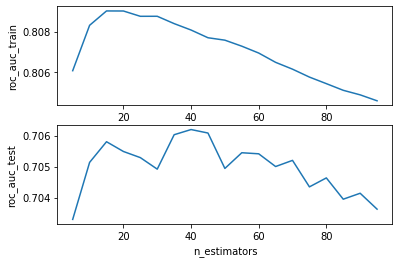











 20%|██        | 1/5 [06:13<24:53, 373.38s/it]

d=1, ch=2


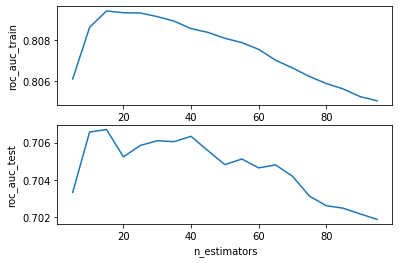











 40%|████      | 2/5 [12:23<18:37, 372.48s/it]

d=1, ch=3


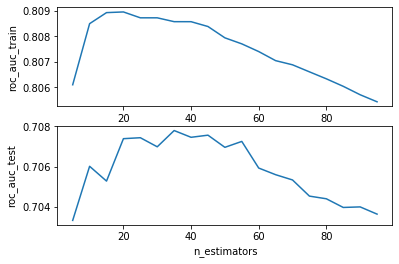











 60%|██████    | 3/5 [18:31<12:22, 371.20s/it]

d=1, ch=4


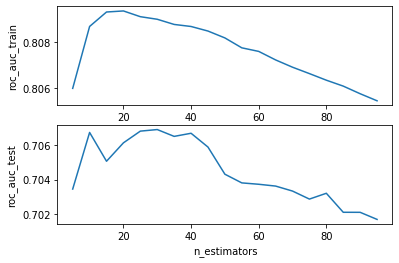











 80%|████████  | 4/5 [24:44<06:11, 371.46s/it]

d=1, ch=5


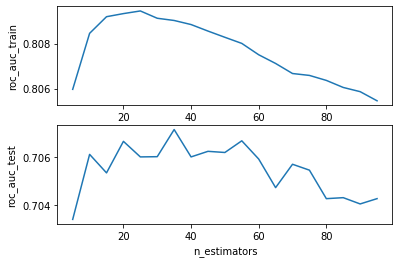











100%|██████████| 5/5 [30:51<00:00, 370.39s/it]








 11%|█         | 1/9 [30:51<4:06:55, 1851.93s/it]









  0%|          | 0/5 [00:00<?, ?it/s]

d=2, ch=1


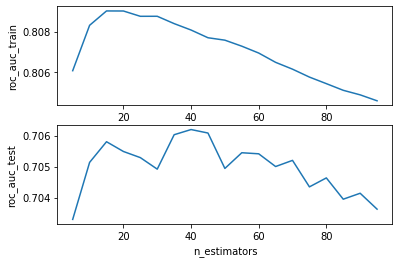











 20%|██        | 1/5 [06:14<24:56, 374.02s/it]

d=2, ch=2


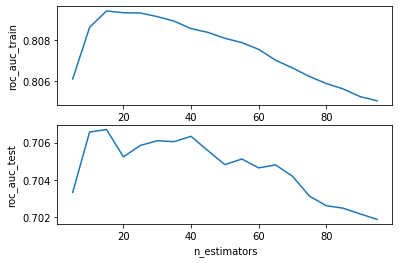











 40%|████      | 2/5 [12:28<18:42, 374.14s/it]

d=2, ch=3


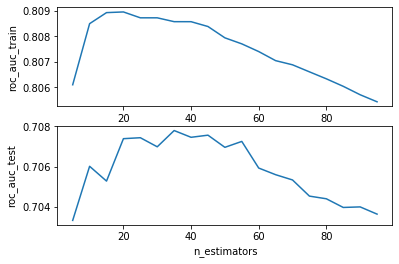











 60%|██████    | 3/5 [18:32<12:22, 371.21s/it]

d=2, ch=4


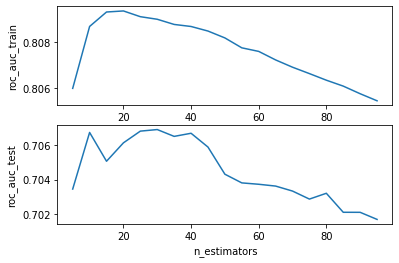











 80%|████████  | 4/5 [24:44<06:11, 371.31s/it]

d=2, ch=5


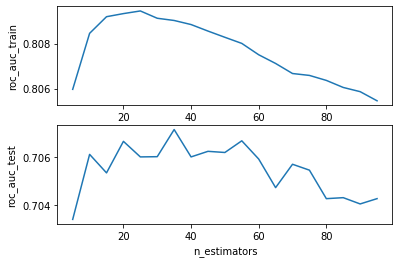











100%|██████████| 5/5 [30:47<00:00, 368.84s/it]








 22%|██▏       | 2/9 [1:01:39<3:35:54, 1850.58s/it]









  0%|          | 0/5 [00:00<?, ?it/s]

d=3, ch=1


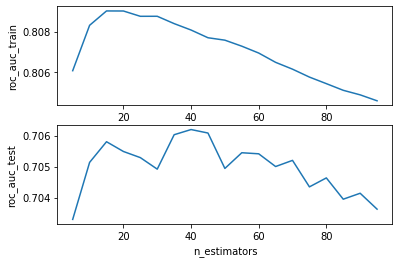











 20%|██        | 1/5 [06:07<24:28, 367.00s/it]

d=3, ch=2


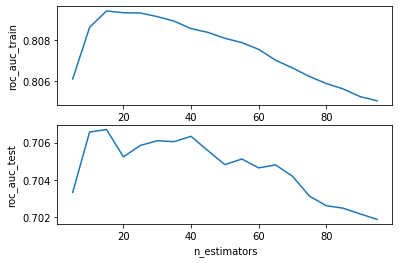











 40%|████      | 2/5 [12:16<18:22, 367.63s/it]

d=3, ch=3


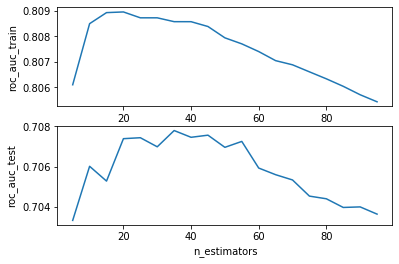











 60%|██████    | 3/5 [18:33<12:21, 370.68s/it]

d=3, ch=4


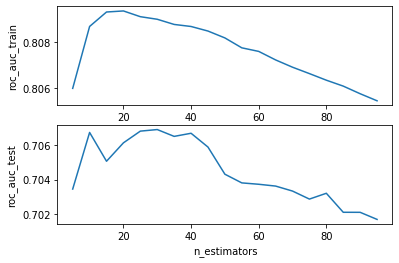











 80%|████████  | 4/5 [24:51<06:12, 372.74s/it]

d=3, ch=5


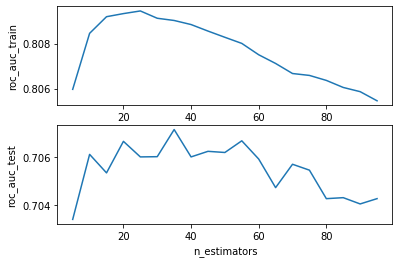











100%|██████████| 5/5 [31:00<00:00, 371.72s/it]








 33%|███▎      | 3/9 [1:32:40<3:05:21, 1853.64s/it]









  0%|          | 0/5 [00:00<?, ?it/s]

d=4, ch=1


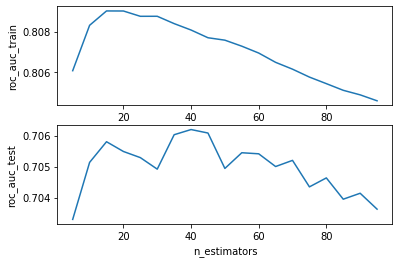











 20%|██        | 1/5 [06:14<24:58, 374.74s/it]

d=4, ch=2


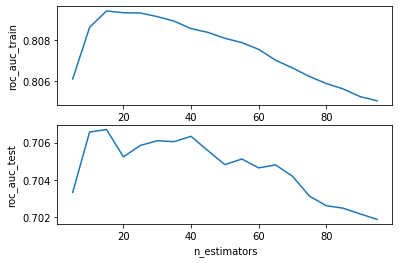











 40%|████      | 2/5 [12:33<18:48, 376.03s/it]

d=4, ch=3


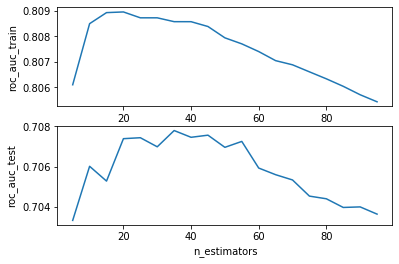











 60%|██████    | 3/5 [18:49<12:32, 376.08s/it]

d=4, ch=4


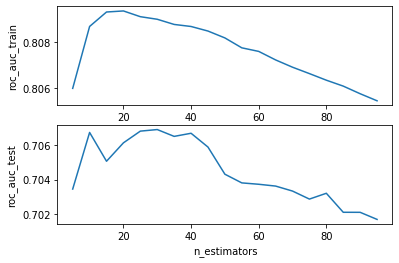











 80%|████████  | 4/5 [25:01<06:14, 374.57s/it]

d=4, ch=5


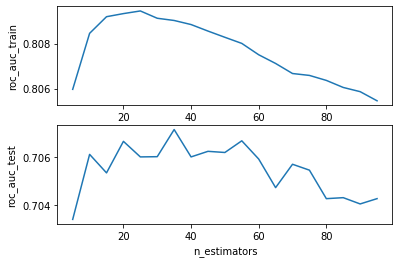











100%|██████████| 5/5 [31:11<00:00, 373.40s/it]








 44%|████▍     | 4/9 [2:03:51<2:34:55, 1859.06s/it]









  0%|          | 0/5 [00:00<?, ?it/s]

d=5, ch=1


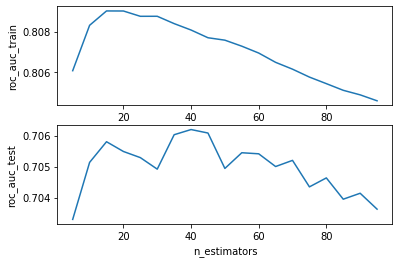











 20%|██        | 1/5 [06:07<24:28, 367.11s/it]

d=5, ch=2


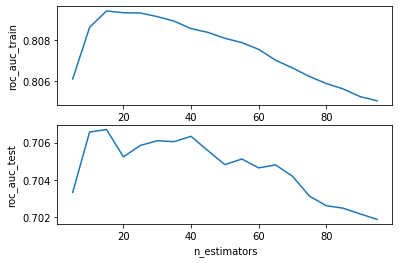











 40%|████      | 2/5 [12:25<18:31, 370.37s/it]

d=5, ch=3


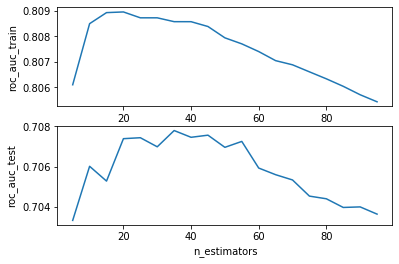











 60%|██████    | 3/5 [18:53<12:31, 375.79s/it]

d=5, ch=4


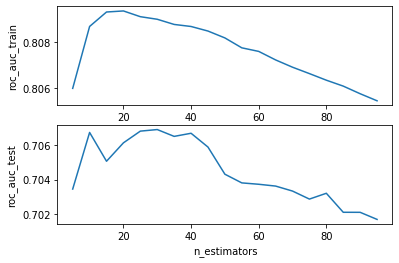











 80%|████████  | 4/5 [25:05<06:14, 374.71s/it]

d=5, ch=5


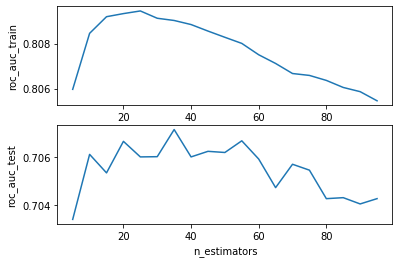











100%|██████████| 5/5 [31:15<00:00, 373.32s/it]








 56%|█████▌    | 5/9 [2:35:07<2:04:16, 1864.08s/it]









  0%|          | 0/5 [00:00<?, ?it/s]

d=6, ch=1


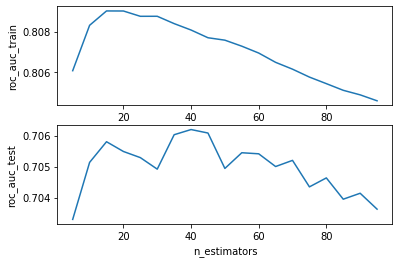











 20%|██        | 1/5 [06:14<24:56, 374.21s/it]

d=6, ch=2


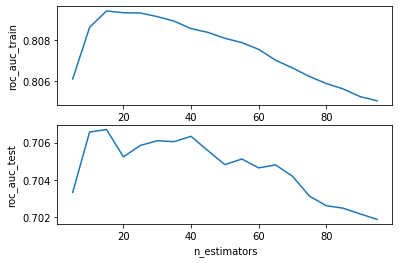











 40%|████      | 2/5 [12:21<18:36, 372.02s/it]

d=6, ch=3


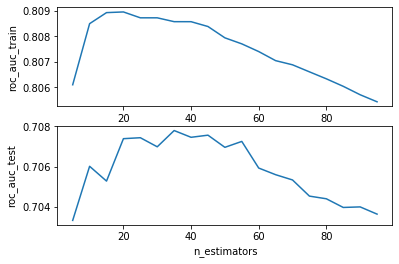











 60%|██████    | 3/5 [18:25<12:19, 369.79s/it]

d=6, ch=4


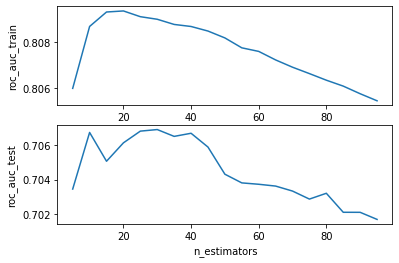











 80%|████████  | 4/5 [24:32<06:08, 368.76s/it]

d=6, ch=5


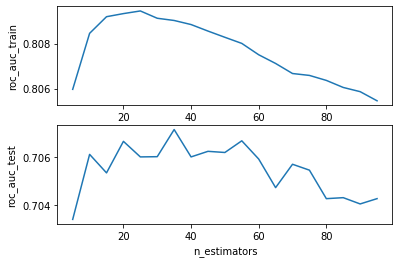











100%|██████████| 5/5 [30:43<00:00, 369.51s/it]








 67%|██████▋   | 6/9 [3:05:50<1:32:53, 1857.86s/it]









  0%|          | 0/5 [00:00<?, ?it/s]

d=7, ch=1


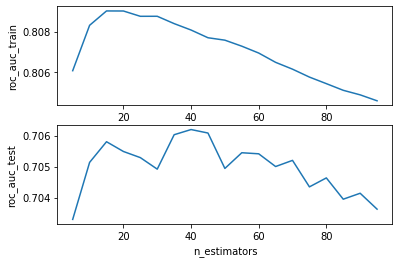











 20%|██        | 1/5 [06:11<24:47, 371.84s/it]

d=7, ch=2


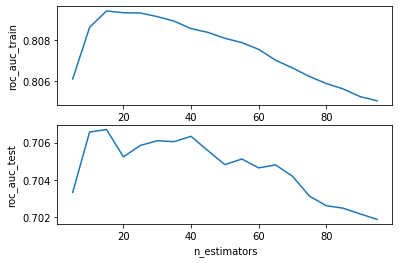











 40%|████      | 2/5 [12:24<18:36, 372.06s/it]

d=7, ch=3


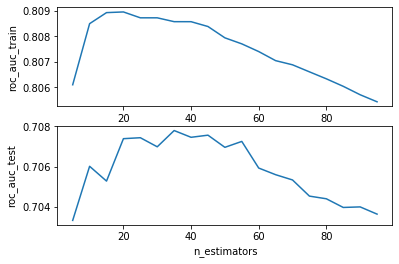











 60%|██████    | 3/5 [18:32<12:21, 370.93s/it]

d=7, ch=4


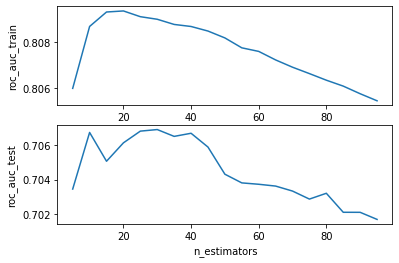











 80%|████████  | 4/5 [24:43<06:10, 370.99s/it]

d=7, ch=5


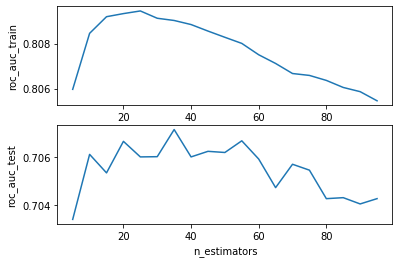











100%|██████████| 5/5 [30:49<00:00, 369.43s/it]








 78%|███████▊  | 7/9 [3:36:40<1:01:50, 1855.39s/it]









  0%|          | 0/5 [00:00<?, ?it/s]

d=8, ch=1


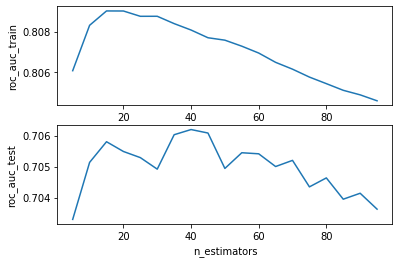











 20%|██        | 1/5 [06:08<24:32, 368.07s/it]

d=8, ch=2


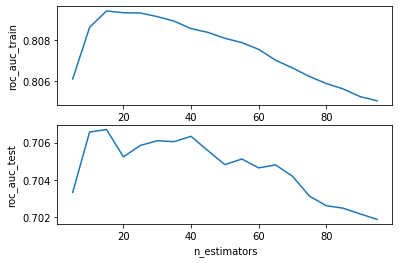











 40%|████      | 2/5 [12:16<18:24, 368.29s/it]

d=8, ch=3


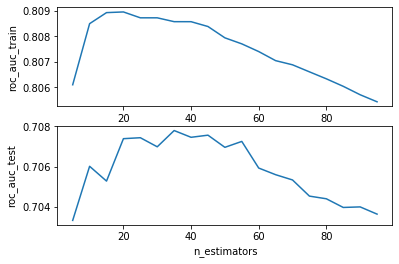











 60%|██████    | 3/5 [18:24<12:16, 368.04s/it]

d=8, ch=4


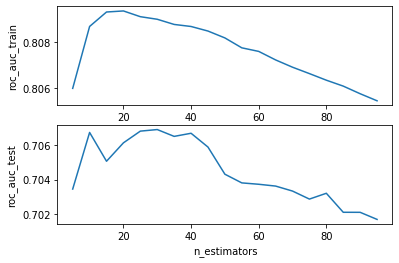











 80%|████████  | 4/5 [24:44<06:11, 371.64s/it]

d=8, ch=5


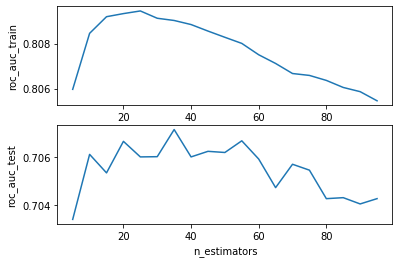











100%|██████████| 5/5 [31:03<00:00, 373.83s/it]








 89%|████████▉ | 8/9 [4:07:43<30:57, 1857.77s/it]  









  0%|          | 0/5 [00:00<?, ?it/s]

d=9, ch=1


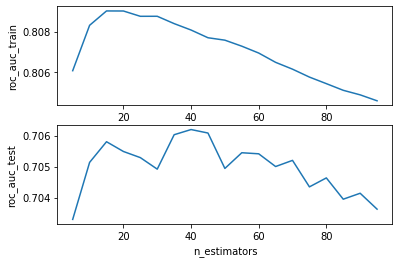











 20%|██        | 1/5 [06:06<24:24, 366.12s/it]

d=9, ch=2


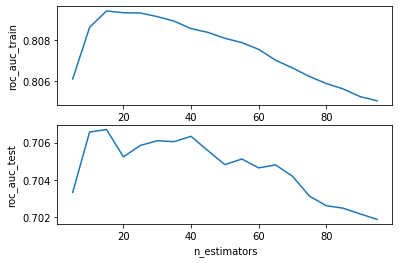











 40%|████      | 2/5 [12:17<18:23, 367.80s/it]

d=9, ch=3


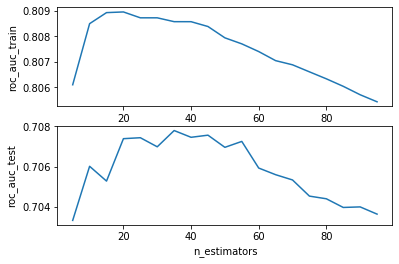











 60%|██████    | 3/5 [18:30<12:18, 369.17s/it]

d=9, ch=4


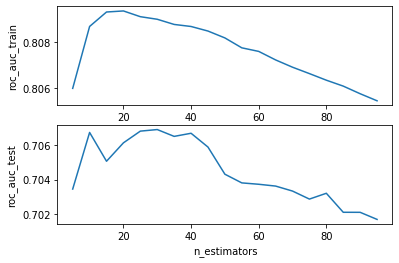











 80%|████████  | 4/5 [24:35<06:08, 368.01s/it]

d=9, ch=5


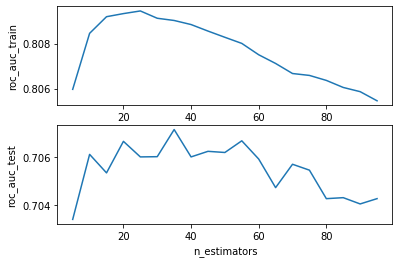











100%|██████████| 5/5 [30:39<00:00, 366.72s/it]








100%|██████████| 9/9 [4:38:23<00:00, 1852.21s/it]

In [252]:
from tqdm import tqdm
mas1=[]
mas2=[]
START=5
STOP=100
STEP=5
random_seed=555
for d in tqdm(range(1,10,1)):
    for ch in tqdm(range(1,6,1)):
        mas1=[]
        mas2=[]
        print("d={}, ch={}".format(d,ch))
        for i in range(START,STOP,STEP):
            tek_clf=XGBClassifier(n_estimators=i,depth=d,min_child_weight=ch, random_seed=555)
            tek_clf.fit( X_train, y_train)
            y_pred=tek_clf.predict( X_test)
            y_pred=list(map(int,y_pred))
            tek_score=roc_auc_score(y_test,y_pred)
            mas1.append(cross_val_score(tek_clf,X_train,y_train,scoring='roc_auc',cv=3).mean())
            mas2.append(tek_score)
            
        x=np.arange(START,STOP,STEP)
        y1=mas1
        y2=mas2
        plt.subplot(2,1,1)
        plt.plot(x,y1)
        plt.xlabel('n_estimators')
        plt.ylabel('roc_auc_train')

        plt.subplot(2,1,2)
        plt.plot(x,y2)
        plt.xlabel('n_estimators')
        plt.ylabel('roc_auc_test')

        plt.show()

In [253]:
for i in range(1,13):
    a=1+11*(i-1)
    b=1+11*i
    tek_table=otv.iloc[:,a:b]
    target=otv['has_trip_here' + str(i)]
    tt=tek_table.drop(columns=['has_trip_here'+str(i)])
    
    X_train, X_test, y_train, y_test = train_test_split(tt, target, train_size=0.8)
    tek_clf=XGBClassifier(n_estimators=35,depth=5,min_child_weight=3,random_seed=555)
    tek_clf.fit( X_train, y_train)

    y_pred=tek_clf.predict( X_test)
    tek_score=roc_auc_score(y_test,y_pred)
    
    cv_score=cross_val_score(tek_clf,X_train,y_train,scoring='roc_auc',cv=3).mean()
    

    print("srez={},score= {}, cv_score={}".format(i,tek_score,cv_score))

srez=1,score= 0.6786222865450828, cv_score=0.7676589303533082
srez=2,score= 0.6972237734797448, cv_score=0.7790692741169112
srez=3,score= 0.6969447236058254, cv_score=0.7958337749581492
srez=4,score= 0.7076120780415041, cv_score=0.7951637445043923
srez=5,score= 0.7026869636859833, cv_score=0.7980738440126398
srez=6,score= 0.6773145479414767, cv_score=0.7929694597570066
srez=7,score= 0.6883873570998226, cv_score=0.7945369002901153
srez=8,score= 0.6899160137258611, cv_score=0.79436467797141
srez=9,score= 0.7080736084237612, cv_score=0.7946402320220444
srez=10,score= 0.7008286450697572, cv_score=0.7969091880157265
srez=11,score= 0.7086134282284375, cv_score=0.805493904512956
srez=12,score= 0.7021310512439383, cv_score=0.8095125376966518


In [20]:
target=table['has_trip_here']

In [21]:
table.head(5)

,acct_num_share,has_trip_here,had_trip_last_year,since_last_trip,since_first_trip,razmah_days_in_trip,days_in_trip,amt_countries,1_m12,2_m12,3_m12,4_m12
0,604ee6361f8a853c947ede4e3c9da372,0.0,0.0,234.0,251.0,17.0,14.0,2.0,14756.0,983.733333,865.0,775.467985
1,eb21cc0143d96dbc8e3a58f1a81e4dd2,0.0,1.0,54.0,328.0,274.0,18.0,1.0,26923.0,480.767857,40.0,657.099851
2,ce1b5f6b6ffc868d72b87efc35e7cfa1,0.0,0.0,338.0,338.0,0.0,1.0,2.0,0.0,0.000000,0.0,0.000000
3,6fd7b9e7820afd1ae1c663561b515784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20635.0,897.173913,663.0,883.922122
4,196417dcee040658875647a566d33f1b,0.0,1.0,31.0,277.0,246.0,57.0,4.0,36280.0,2418.666667,545.0,5464.707429


In [22]:
table.drop(columns=['acct_num_share','has_trip_here'],inplace=True)

In [23]:

X_train, X_test, y_train, y_test = train_test_split(table, target, train_size=0.8)
print(X_train.shape, X_test.shape)

(100112, 10) (25029, 10)


In [25]:
from tqdm import tqdm
mas1=[]
mas2=[]
START=10
STOP=1020
STEP=100
random_seed=555

for i in tqdm(range(START,STOP,STEP)):
    tek_clf=XGBClassifier(n_estimators=i,random_seed=555)
    tek_clf.fit( X_train, y_train)
    y_pred=tek_clf.predict( X_test)
    y_pred=list(map(int,y_pred))
    tek_score=roc_auc_score(y_test,y_pred)
    mas1.append(cross_val_score(tek_clf,X_train,y_train,scoring='roc_auc',cv=3).mean())
    mas2.append(tek_score)
            

100%|██████████| 11/11 [36:43<00:00, 309.42s/it]


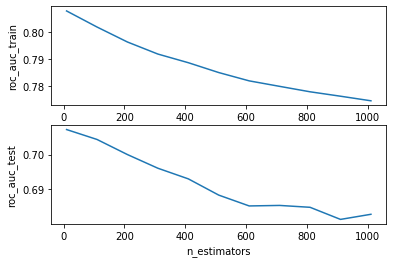

In [27]:
x=np.arange(START,STOP,STEP)
y1=mas1
y2=mas2
plt.subplot(2,1,1)
plt.plot(x,y1)
plt.xlabel('n_estimators')
plt.ylabel('roc_auc_train')

plt.subplot(2,1,2)
plt.plot(x,y2)
plt.xlabel('n_estimators')
plt.ylabel('roc_auc_test')

plt.show()
